In [1]:
# !pip install tensorflow==2.4.1

In [2]:
# COLAB ONLY
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
from sklearn import ensemble
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_curve, auc, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA, TruncatedSVD

from multiprocessing.pool import ThreadPool
from multiprocessing import Pool 
from scipy.stats import ks_2samp

# from xgboost import XGBClassifier
# from catboost import CatBoostClassifier
# from lightgbm import LGBMClassifier

In [4]:
print(tf.__version__)

2.4.1


In [5]:
# Data loading
folder_path = '/content/drive/MyDrive/Data/colabs_data/WiDS' #Kaggle: ../input/widsdatathon2021/ #Local PC: '.'
df_train = pd.read_csv(folder_path + "/TrainingWiDS2021.csv")
df_test = pd.read_csv(folder_path + "/UnlabeledWiDS2021.csv")
print(df_train.shape)
print(df_test.shape)

(130157, 181)
(10234, 180)


In [6]:
# Data type 
# ['hospital_id']
col_target = 'diabetes_mellitus'
cols_id = ['encounter_id', 'Unnamed: 0']
cols_cat = [i for i in df_train.select_dtypes('object').columns if i not in cols_id + [col_target]]
cols_num = [i for i in df_train if i not in cols_cat + cols_id + [col_target] ]
cols_ft = cols_cat + cols_num

In [7]:
df_ft_full = pd.concat( [df_train[cols_ft], df_test[cols_ft]], axis = 0)
df_ft_full[cols_num] = df_ft_full[cols_num].fillna(0)
df_ft_full[cols_cat] = df_ft_full[cols_cat].fillna('missing')
# df_ft_full = df_ft_full.reset_index(drop = True)
    
# df_ft_full[cols_cat] = df_ft_full[cols_cat].astype('object')
# df_ft_full[cols_num] = df_ft_full[cols_num].astype('float64')

# EDA

In [9]:
def evaluate_binary_cross_entropy(df, target_col):
    cols_ = [i for i in df.columns if i != target_col ]
    ce_list = {}
    for col in cols_:
        x = df[ [col, target_col] ].groupby(col).agg({target_col: lambda x: np.sum(x)/len(x), col:lambda x: len(x)/df.shape[0]}).dropna()
        x.columns = ['p', 'q']
        ce = -sum([x.iloc[i,:]['p']*np.log2(x.iloc[i,:]['q']) for i in range(len(x))])
        ce_list[col] = ce 
    return ce_list

ce_dict = evaluate_binary_cross_entropy(df_train[cols_cat + [col_target]], col_target)

In [10]:
def evaluate_num_bce(df, target_col, bin = 100):
    '''evaluate binary cross entropy of the numeric data'''
    cols_ = [i for i in df.columns if i != target_col ]
    ce_list = {}
    df = df.copy()
    for col in cols_:
        df[col] = pd.cut(df[col], bin)
    return evaluate_binary_cross_entropy(df, target_col)

ce_num_list = evaluate_num_bce(df_train[cols_num + [col_target]], col_target)

In [22]:
ce_num_df = pd.DataFrame.from_dict(ce_num_list, orient='index', columns = ['cross_entropy'])
ce_num_df.sort_values('cross_entropy', ascending= 0 )[:10]#.plot(kind = 'bar')
top_ft = list( ce_num_df.sort_values('cross_entropy', ascending= 0 )[:10].index )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


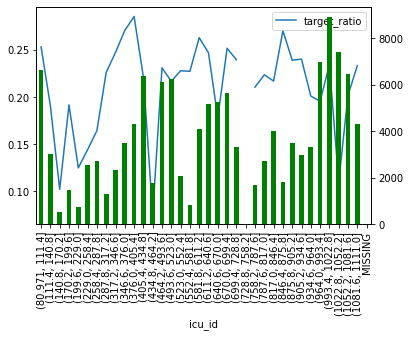

In [49]:
# Numeric column checking
def check_numeric_column(col):
  x = df_train[[col, col_target]]
  x[col] = pd.cut(x[col], 35).cat.add_categories('MISSING').fillna('MISSING')
  x = x.groupby(col).agg({col_target: lambda x: np.sum(x)/len(x), col:lambda x: len(x)})
  x.columns = ['target_ratio', 'freq']
  x = x.sort_index()#.sort_values(by = 'target_ratio')
  ax = x['target_ratio'].plot(label = 'target_ratio')
  x['freq'].plot(kind = 'bar', ax = ax, secondary_y = True, color = 'green')
  ax.legend(loc = 'best')
  plt.show()
  return x 

x = check_numeric_column('icu_id')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


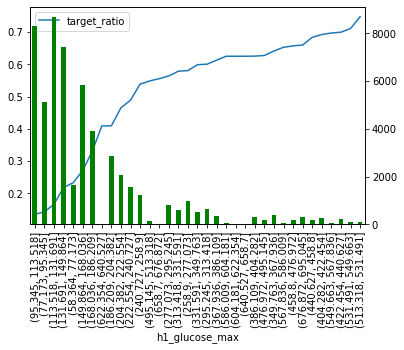

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


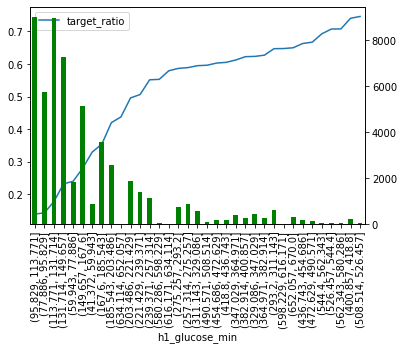

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


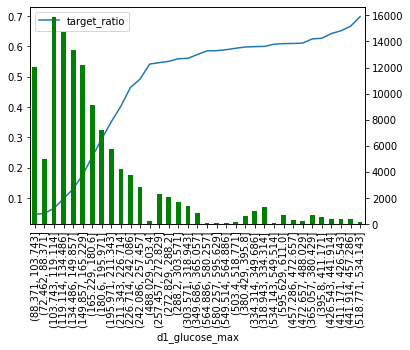

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


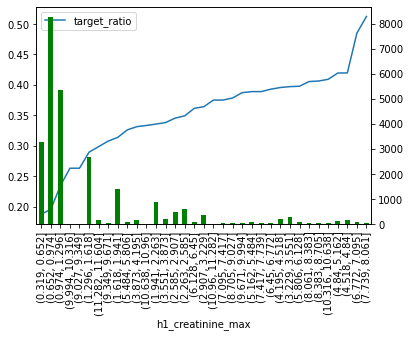

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


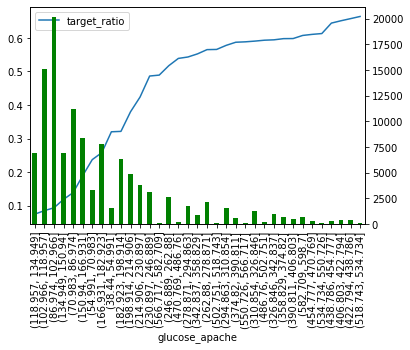

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


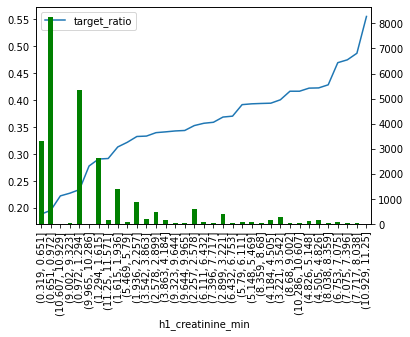

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


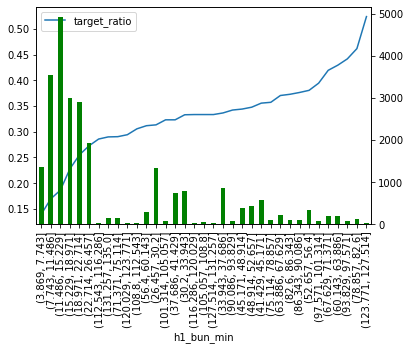

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


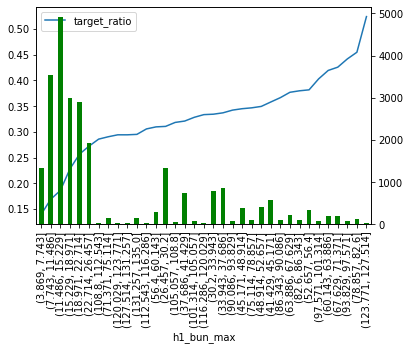

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


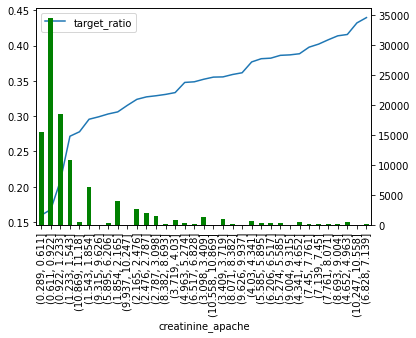

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


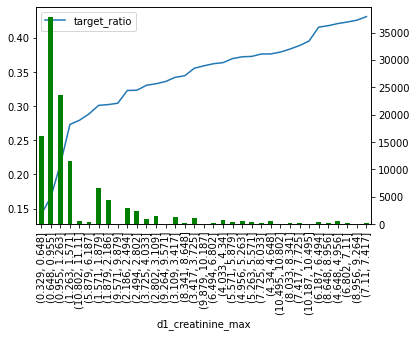

In [27]:
for i in top_ft:
  check_numeric_column(i)

In [ ]:
cols_cat

['ethnicity',
 'gender',
 'hospital_admit_source',
 'icu_admit_source',
 'icu_stay_type',
 'icu_type']

        target_ratio  freq
icu_id                    
144         0.000000    13
552         0.000000     8
603         0.000000     2
534         0.000000     8
531         0.000000     4
...              ...   ...
685         0.362398   734
364         0.363636    77
698         0.372727   110
641         0.395349    43
365         0.500000     2

[328 rows x 2 columns]


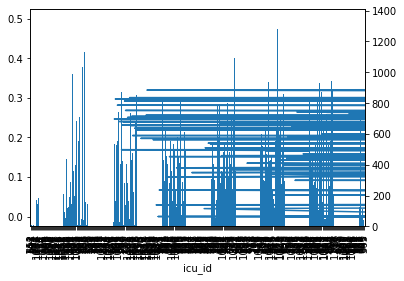

In [44]:
# Categorical column checking
col = 'icu_id'
x = df_train[[col, col_target]]
x = x.fillna('MISSING').groupby(col).agg({col_target: lambda x: np.sum(x)/len(x), col:lambda x: len(x)})
x.columns = ['target_ratio', 'freq']
x = x.sort_values(by = 'target_ratio')
ax = x['target_ratio'].plot()
x['freq'].plot(kind = 'bar', ax = ax, secondary_y = True)
print(x)

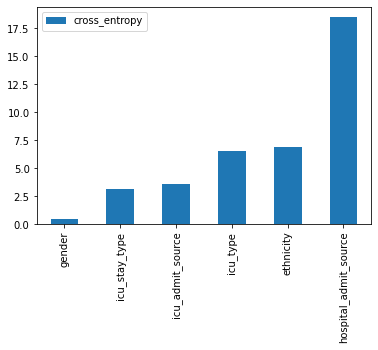

In [ ]:
ce_df = pd.DataFrame.from_dict(ce_dict, orient='index', columns = ['cross_entropy'])
ce_df.sort_values('cross_entropy').plot(kind = 'bar')

In [ ]:
def _feature_generation(df):
    df = df.copy()
    # hospital_admit_source = other => nhãn 0
    df['hospital_admit_source_unknow'] = df['hospital_admit_source'].fillna('Other').apply(lambda x: 1 if x == 'Other' else 0)
    return df 

_feature_generation(df_train.head())

,Unnamed: 0,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,...,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus,hospital_admit_source_unknow
0,1,214826,118,68.0,22.732803,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.9,2.3,113.0,502.01,0,0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0,40.0,NaN,NaN,NaN,NaN,36.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1,1
1,2,246060,81,77.0,27.421875,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0.927778,0,70.2,NaN,108.0,203.01,0,0,NaN,9.0,0.56,1.0,1.0,3.0,0.0,1.0,145.0,120.0,36.9,0,46.0,37.0,37.0,51.0,7.45,33.0,...,11.3,36.9,36.9,1.3,1.3,3.5,3.5,557.0,557.0,4.2,4.2,145.0,145.0,12.7,12.7,37.0,37.0,7.45,7.45,51.0,51.0,54.8,51.000000,37.0,37.0,7.45,7.45,51.0,51.0,51.0,51.0,0,0,0,0,0,0,0,1,1
2,3,276985,118,25.0,31.952749,0,Caucasian,F,172.7,Emergency Department,Accident & Emergency,93,admit,Med-Surg ICU,0.000694,0,95.3,NaN,122.0,703.03,0,0,NaN,NaN,NaN,NaN,3.0,6.0,0.0,5.0,NaN,102.0,NaN,0,68.0,NaN,NaN,NaN,NaN,37.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1
3,4,262220,118,81.0,22.635548,1,Caucasian,F,165.1,Operating Room,Operating Room / Recovery,92,admit,CTICU,0.000694,0,61.7,NaN,203.0,1206.03,1,0,NaN,NaN,NaN,0.6,4.0,6.0,0.0,5.0,185.0,114.0,25.9,1,60.0,30.0,30.0,142.0,7.39,4.0,...,11.6,34.0,34.0,1.6,1.1,NaN,NaN,43.0,43.0,NaN,NaN,NaN,NaN,8.8,8.8,37.0,27.0,7.44,7.34,337.0,102.0,342.5,236.666667,36.0,33.0,7.37,7.34,337.0,265.0,337.0,337.0,0,0,0,0,0,0,0,0,1
4,5,201746,33,19.0,NaN,0,Caucasian,M,188.0,NaN,Accident & Emergency,91,admit,Med-Surg ICU,0.073611,0,NaN,NaN,119.0,601.01,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,NaN,0,103.0,NaN,NaN,NaN,NaN,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0


In [43]:
df_train.columns

Index(['Unnamed: 0', 'encounter_id', 'hospital_id', 'age', 'bmi',
       'elective_surgery', 'ethnicity', 'gender', 'height',
       'hospital_admit_source',
       ...
       'h1_pao2fio2ratio_max', 'h1_pao2fio2ratio_min', 'aids', 'cirrhosis',
       'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma',
       'solid_tumor_with_metastasis', 'diabetes_mellitus'],
      dtype='object', length=181)

In [ ]:
class TargetEncoder(BaseEstimator, TransformerMixin):
    """Target encoder.
    Replaces categorical column(s) with the mean target value for each category.
    """
    
    def __init__(self, cols=None):
        """Target encoder
        Parameters
        ----------
        cols : list of str
            Columns to target encode.  Default is to target 
            encode all categorical columns in the DataFrame.
        """
        if isinstance(cols, str):
            self.cols = [cols]
        else:
            self.cols = cols
        
        
    def fit(self, X, y):
        """Fit target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [col for col in X 
                         if str(X[col].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        # Encode each element of each column
        self.maps = dict() #dict to store map for each column
        for col in self.cols:
            tmap = dict()
            uniques = X[col].unique()
            for unique in uniques:
                tmap[unique] = y[X[col]==unique].mean()
            self.maps[col] = tmap
            
        return self

        
    def transform(self, X, y=None):
        """Perform the target encoding transformation.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
            
        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        Xo = X.copy()
        for col, tmap in self.maps.items():
            vals = np.full(X.shape[0], np.nan)
            for val, mean_target in tmap.items():
                vals[X[col]==val] = mean_target
            Xo[col] = vals
        return Xo
            
            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)

In [ ]:
Target_ecoder = TargetEncoder()
Target_ecoder.fit(df_train[cols_cat], df_train[col_target])

TargetEncoder(cols=['ethnicity', 'gender', 'hospital_admit_source',
                    'icu_admit_source', 'icu_stay_type', 'icu_type'])

In [ ]:
cols_cat

['ethnicity',
 'gender',
 'hospital_admit_source',
 'icu_admit_source',
 'icu_stay_type',
 'icu_type']

evaluate at: ethnicity


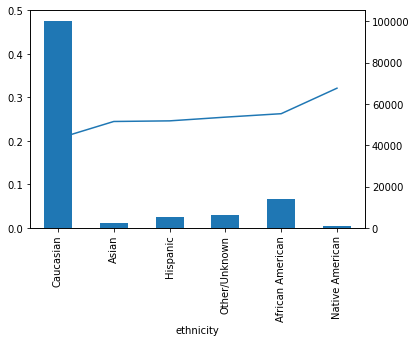

evaluate at: gender


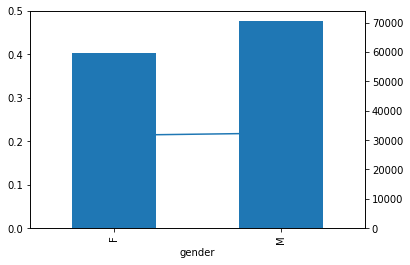

evaluate at: hospital_admit_source


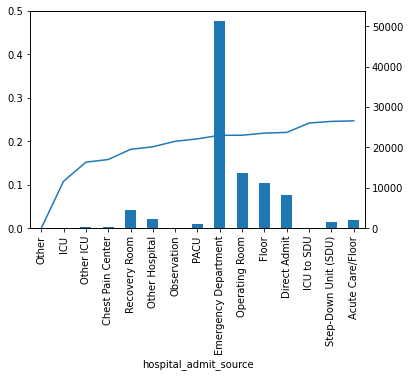

evaluate at: icu_admit_source


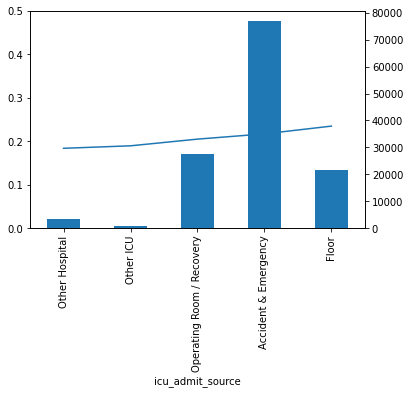

evaluate at: icu_stay_type


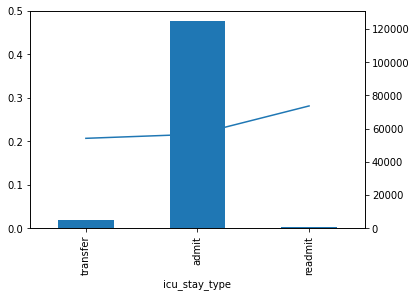

evaluate at: icu_type


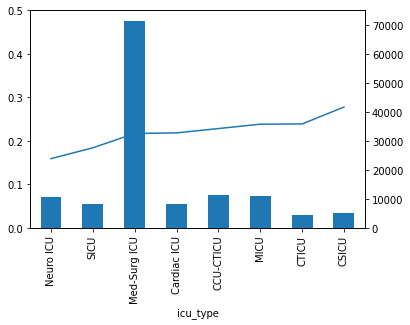

In [ ]:
for col in cols_cat:
  print('evaluate at:', col)
  x = df_train[[col, col_target]].groupby(col).agg({col_target: lambda x: np.sum(x)/len(x), col:lambda x: len(x)})
  x.columns = ['target_ratio', 'freq']
  x = x.sort_values(by = 'target_ratio')
  ax = x['target_ratio'].plot(ylim = [0, 0.5])
  x['freq'].plot(kind = 'bar', ax = ax, secondary_y = True)
  plt.show()

In [ ]:
col = 'hospital_admit_source'
x = df_train[[col, col_target]].groupby(col).agg({col_target: [lambda x: np.sum(x)/len(x), 'sum', 'count']})
x

diabetes_mellitus              
                             <lambda_0>    sum  count
hospital_admit_source                                
Acute Care/Floor               0.247020    518   2097
Chest Pain Center              0.158103     40    253
Direct Admit                   0.220405   1819   8253
Emergency Department           0.213801  10959  51258
Floor                          0.218827   2478  11324
ICU                            0.108108      4     37
ICU to SDU                     0.241935     15     62
Observation                    0.200000      2     10
Operating Room                 0.213927   2943  13757
Other                          0.000000      0      7
Other Hospital                 0.187422    453   2417
Other ICU                      0.151943     43    283
PACU                           0.205626    212   1031
Recovery Room                  0.181460    828   4563
Step-Down Unit (SDU)           0.245800    395   1607

## Kiểm tra + loại bỏ feature có var thấp

In [30]:
cv_check = df_train.var()/df_train.mean()

In [32]:
cv_check.sort_values()

d1_arterial_ph_max         0.000993
ph_apache                  0.001318
h1_arterial_ph_max         0.001529
h1_arterial_ph_min         0.001611
d1_arterial_ph_min         0.001699
                           ...     
apache_3j_diagnosis      384.513368
urineoutput_apache      1178.108724
encounter_id            6818.559442
Unnamed: 0             21692.833333
readmission_status              NaN
Length: 175, dtype: float64

In [34]:
df_train['d1_arterial_ph_max']#.describe()

0           NaN
1         7.450
2           NaN
3         7.440
4           NaN
          ...  
130152      NaN
130153      NaN
130154    7.614
130155      NaN
130156      NaN
Name: d1_arterial_ph_max, Length: 130157, dtype: float64

In [39]:
df_train['d1_arterial_ph_max'].isna().sum()

84807

## DATA SHIFTING CHECK
Dùng kiểm định Kolmogorov–Smirnov test để kiểm tra phân phối train/ test có giống nhau

In [ ]:
ks_2samp(df_train['bmi'].dropna(), df_test['bmi'].dropna())

Ks_2sampResult(statistic=0.011720708543274228, pvalue=0.1887183965912331)

In [ ]:
dict_ks_results = {col: ks_2samp(df_train[col].dropna(), df_test[col].dropna()) for col in cols_ft}
df_ks_results = pd.DataFrame.from_dict(dict_ks_results, orient='index', columns = ['statistics','p_value'])

In [ ]:
ks_2samp(df_train['bmi'], df_test['bmi'])

Ks_2sampResult(statistic=0.06976350875623338, pvalue=1.5551539785395718e-40)

In [ ]:
df_train[['d1_calcium_min']].describe()

,d1_calcium_min
count,113465.000000
mean,8.164674
std,0.793055
min,5.500000
25%,7.700000
50%,8.200000
75%,8.700000
max,10.300000


In [ ]:
df_test[['d1_calcium_min']].describe()

,d1_calcium_min
count,8832.00000
mean,8.07449
std,0.80178
min,5.50000
25%,7.60000
50%,8.10000
75%,8.60000
max,10.20000


In [ ]:
df_ks_results.sort_values('p_value', ascending=1).iloc[:30]

,statistics,p_value
hospital_id,1.000000,0.000000e+00
icu_id,0.050877,9.313698e-22
d1_calcium_min,0.051252,4.032510e-19
d1_calcium_max,0.051023,5.919929e-19
pre_icu_los_days,0.044067,1.984008e-16
age,0.037635,4.593853e-12
d1_diasbp_max,0.037171,8.703297e-12
d1_diasbp_noninvasive_max,0.036632,2.522367e-11
d1_mbp_max,0.035363,1.075999e-10
d1_mbp_noninvasive_max,0.034804,3.330286e-10


In [ ]:
df_train_full = pd.concat( [df_ft_full[:130157],df_train[[col_target]] ], axis = 1 )

In [ ]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=128):
    dataframe = dataframe.copy()
    try:
        labels = dataframe.pop(col_target)
        ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    except:
        ds = tf.data.Dataset.from_tensor_slices((dict(dataframe)))
                                                
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    
    # For performance turning
    AUTOTUNE = tf.data.AUTOTUNE
    ds = ds.cache().prefetch(buffer_size=AUTOTUNE)
    return ds

In [ ]:
batch_size = 1024 # A small batch sized is used for demonstration purposes

df_to_train, df_to_val = train_test_split(df_train_full, test_size = 0.2, shuffle=True)

ds_train = df_to_dataset(df_to_train, batch_size=batch_size)
ds_val = df_to_dataset(df_to_val, shuffle=False, batch_size=batch_size)
ds_test = df_to_dataset(df_ft_full[130157:], shuffle=False, batch_size=batch_size)

In [ ]:
# Check data is correct
for feature_batch, label_batch in ds_train.take(1):
    print('Every feature:', list(feature_batch.keys()))
    print('A batch of ages:', feature_batch['gender'])
    print('A batch of targets:', label_batch )

Every feature: ['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'hospital_id', 'age', 'bmi', 'elective_surgery', 'height', 'icu_id', 'pre_icu_los_days', 'readmission_status', 'weight', 'albumin_apache', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_post_operative', 'arf_apache', 'bilirubin_apache', 'bun_apache', 'creatinine_apache', 'fio2_apache', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache', 'glucose_apache', 'heart_rate_apache', 'hematocrit_apache', 'intubated_apache', 'map_apache', 'paco2_apache', 'paco2_for_ph_apache', 'pao2_apache', 'ph_apache', 'resprate_apache', 'sodium_apache', 'temp_apache', 'urineoutput_apache', 'ventilated_apache', 'wbc_apache', 'd1_diasbp_invasive_max', 'd1_diasbp_invasive_min', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_invasive_max', 'd1_mbp_invasive_min', 'd1_mbp_max', 

In [ ]:
# FEATURE COLUMNS
fcs_num = [tf.feature_column.numeric_column(i) for i in cols_num]
fcs_cat = [
    tf.feature_column.embedding_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            col, vocabulary_list = list(df_ft_full[col].drop_duplicates() )
        ), dimension = int(len(df_ft_full[col].drop_duplicates() ) * 0.9)
    )
    for col in cols_cat
]


In [ ]:
# MLP Nets
model = tf.keras.Sequential([
    tf.keras.layers.DenseFeatures(fcs_num ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(optimizer = 'adam', loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.015), 
              metrics = [tf.keras.metrics.AUC()])

In [ ]:
history = model.fit( ds_train, validation_data = ds_val,
                   epochs = 10, batch_size = 128)

Epoch 1/10
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
102/102 [==============================] - ETA: 0s - loss: 0.6802 - auc: 0.6688WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'ethnicity': <tf.Tensor 'ExpandDims_77:0' shape=(None, 1) dtype=string>, 'gender': <tf.Tensor 'ExpandDims_83:0' shape=(None, 1) dtype=string>, 'hospital_admit_source': <tf.Tensor 'ExpandDims_153:0' shape=(None, 1) dtype=string>, 'icu_admit_source': <tf.Tensor 'ExpandDims_155:0' shape=(None, 1) dtype=string>, 'icu_stay_type': <tf.Tensor 'ExpandDims_157:0' shape=(None, 1) dtype=string>, 'icu_type': <tf.Tensor 'ExpandDims_158:0' shape=(None, 1) dtype=string>, 'hospital_id': <tf.Tensor 'ExpandDims_154:0' shape=(None, 1) dtype=int64>, 'age': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float64>, 'bmi': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=float64>, 'ele

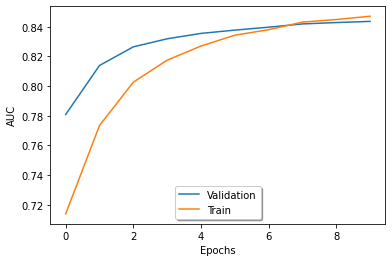

In [ ]:
# Exam results
plt.figure()
plt.ylabel("AUC")
plt.xlabel("Epochs")
# plt.ylim([0,2])
plt.plot(history.history['val_auc'],label='Validation')
plt.plot(history.history['auc'], label='Train')
plt.legend(loc='lower center', shadow=True, fontsize='medium')

### TURNING

In [ ]:
def get_permutation_importance_multiprocessing(model, dataframe, k = 5 , batch_size = 2048, target_col = 'target', metrix_index = 0):
  '''Get permutation feature importance
    * model: model đã được fit
    * k:int: số lần shuffle lại => tăng độ chính xác và giảm tính ngẫu nhiên
    * target_col: str: tên cột target
    * metrix_index: int: thứ tự (từ 0) metrix đánh giá trong số các metrix model cho phép '''
  ds = df_to_dataset( dataframe, shuffle=False, batch_size=batch_size)
  s0 = model.evaluate(ds)[metrix_index] # <-- Model được thiết lập với: 0: loss; 1: AUC
  cols_ft = [i for i in dataframe.columns if i != target_col]
    
  def eval_multiprocessing(col):
    s_i = []
    df_copy = dataframe.copy()
    for i in range(k):  
      df_copy[col] = df_copy[col].sample(frac = 1, random_state = i )
      ds = df_to_dataset( df_copy, shuffle=False, batch_size=batch_size)
      s_i.append( model.evaluate(ds)[metrix_index] )
    return s0 - sum(s_i)/len(s_i) 

  # DÙng ThreadPool để chạy song song 8 columns trong 1 lần => tăng tốc (dùng mp.Pool bị lỗi nên phải dùng ThreadPool)
  with ThreadPool(8) as pool:
    feature_importance = pool.map(lambda col: eval_multiprocessing( col ), cols_ft)
  return dict(zip(cols_ft,feature_importance)) 

fts_importance = get_permutation_importance_multiprocessing(model ,df_to_train, k=5,target_col = col_target, metrix_index = 1 )

13/51 [======>.......................] - ETA: 51s - loss: 0.3751 - auc: 0.8653

In [ ]:
df_fti = pd.DataFrame.from_dict(fts_importance , orient='index', columns = ['dloss'])
df_fti['dl_abs'] = df_fti['dloss'].abs()
df_fti.sort_values(by ='dl_abs', ascending=False).head(50)['dloss'].sort_values().plot(kind='barh', figsize=(10, 15))

## PREDICT FINAL SUBMISSION

In [ ]:
df_test['diabetes_mellitus'] = model.predict(ds_test)

In [ ]:
df_ss = df_test[['encounter_id', 'diabetes_mellitus']]
df_ss.to_csv('./submission.csv', index = False)